In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable, grad
import torch.nn.utils.spectral_norm as spectral_norm

In [3]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [5]:
# Enable GPU if available
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device}")

Using cuda


In [7]:
# Hyperparameters
batch_size = 32  # Massively reduced
lr = 0.0002
lr_generator = 0.01  # Higher
latent_dim = 4  # Reduce latent space to induce mode collapse
n_epochs = 5
lambda_gp = 10
d_updates = 5  # Number of discriminator updates per generator update

Ways to induce mode collapse:
- A small latent space limits the generator's ability to produce diverse outputs.
- Overfit the discriminator by training it much more frequently (D steps > G steps). The generator will exploit weak patterns in the discriminator and produce repetitive outputs.
- Reduced batch size to reduce diversity of images in training data sent at a time
- Higher learning rate for the generator

https://pub.towardsai.net/gan-mode-collapse-explanation-fa5f9124ee73

In [8]:
# CIFAR-10 Dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root="./data", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)


Files already downloaded and verified


In [9]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 128, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(128, 256, 4, stride=2, padding=1)),
            nn.LayerNorm([256, 8, 8]),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, img):
        return self.model(img).view(-1)


# Gradient Penalty
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(
        True
    )
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size(), device=device)
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [15]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr_generator, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

# Fixed noise for testing mode collapse
fixed_noise = torch.zeros(batch_size, latent_dim, device=device)

[Epoch 0/5] [Batch 0/1563] [D loss: 13847.6445] [G loss: -0.3413]
[Epoch 0/5] [Batch 100/1563] [D loss: 0.0258] [G loss: -0.3711]
[Epoch 0/5] [Batch 200/1563] [D loss: 0.0274] [G loss: -0.3879]
[Epoch 0/5] [Batch 300/1563] [D loss: 0.0108] [G loss: -0.3907]
[Epoch 0/5] [Batch 400/1563] [D loss: 0.0019] [G loss: -0.3907]
[Epoch 0/5] [Batch 500/1563] [D loss: 0.0013] [G loss: -0.3904]
[Epoch 0/5] [Batch 600/1563] [D loss: 0.0049] [G loss: -0.3903]
[Epoch 0/5] [Batch 700/1563] [D loss: 0.0014] [G loss: -0.3900]
[Epoch 0/5] [Batch 800/1563] [D loss: 0.0050] [G loss: -0.3900]
[Epoch 0/5] [Batch 900/1563] [D loss: 0.0011] [G loss: -0.3899]
[Epoch 0/5] [Batch 1000/1563] [D loss: 0.0009] [G loss: -0.3899]
[Epoch 0/5] [Batch 1100/1563] [D loss: 0.0014] [G loss: -0.3898]
[Epoch 0/5] [Batch 1200/1563] [D loss: 0.0012] [G loss: -0.3898]
[Epoch 0/5] [Batch 1300/1563] [D loss: 0.0027] [G loss: -0.3897]
[Epoch 0/5] [Batch 1400/1563] [D loss: 0.0007] [G loss: -0.3896]
[Epoch 0/5] [Batch 1500/1563] [D 

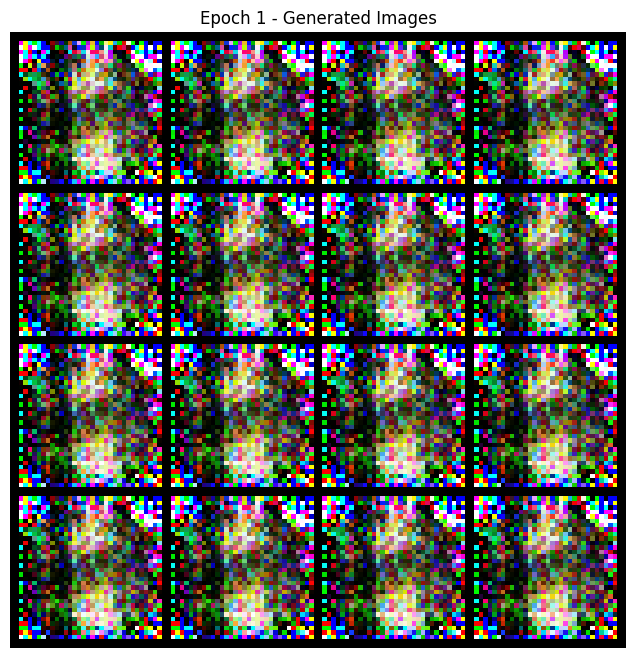

[Epoch 1/5] [Batch 0/1563] [D loss: 0.0022] [G loss: -0.3892]
[Epoch 1/5] [Batch 100/1563] [D loss: 0.0041] [G loss: -0.3892]
[Epoch 1/5] [Batch 200/1563] [D loss: 0.0007] [G loss: -0.3890]
[Epoch 1/5] [Batch 300/1563] [D loss: 0.0036] [G loss: -0.3889]
[Epoch 1/5] [Batch 400/1563] [D loss: 0.0014] [G loss: -0.3888]
[Epoch 1/5] [Batch 500/1563] [D loss: 0.0007] [G loss: -0.3887]
[Epoch 1/5] [Batch 600/1563] [D loss: 0.0012] [G loss: -0.3889]
[Epoch 1/5] [Batch 700/1563] [D loss: 0.0006] [G loss: -0.3888]
[Epoch 1/5] [Batch 800/1563] [D loss: 0.0012] [G loss: -0.3889]
[Epoch 1/5] [Batch 900/1563] [D loss: 0.0011] [G loss: -0.3887]
[Epoch 1/5] [Batch 1000/1563] [D loss: 0.0005] [G loss: -0.3887]
[Epoch 1/5] [Batch 1100/1563] [D loss: 0.0009] [G loss: -0.3887]
[Epoch 1/5] [Batch 1200/1563] [D loss: 0.0004] [G loss: -0.3888]
[Epoch 1/5] [Batch 1300/1563] [D loss: 0.0009] [G loss: -0.3889]
[Epoch 1/5] [Batch 1400/1563] [D loss: 0.0005] [G loss: -0.3891]
[Epoch 1/5] [Batch 1500/1563] [D loss

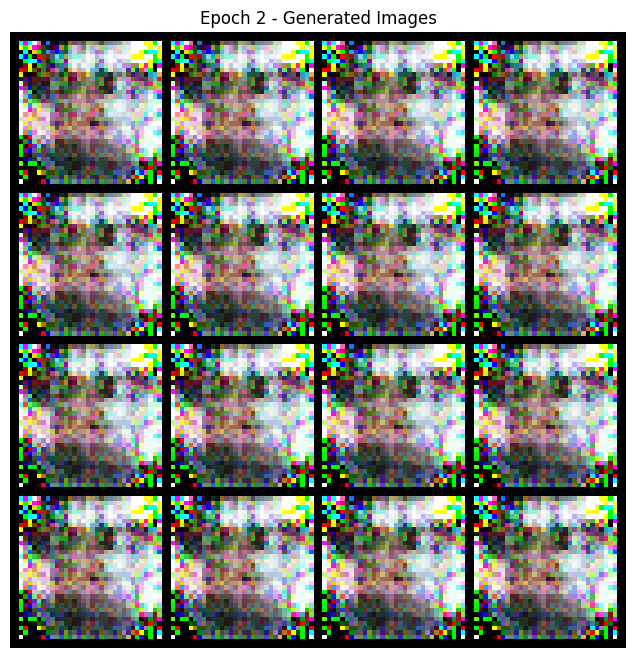

[Epoch 2/5] [Batch 0/1563] [D loss: 0.0005] [G loss: -0.3892]
[Epoch 2/5] [Batch 100/1563] [D loss: 0.0006] [G loss: -0.3892]
[Epoch 2/5] [Batch 200/1563] [D loss: 0.0004] [G loss: -0.3893]
[Epoch 2/5] [Batch 300/1563] [D loss: 0.0002] [G loss: -0.3894]
[Epoch 2/5] [Batch 400/1563] [D loss: 0.0003] [G loss: -0.3898]
[Epoch 2/5] [Batch 500/1563] [D loss: 0.0003] [G loss: -0.3898]
[Epoch 2/5] [Batch 600/1563] [D loss: 0.0003] [G loss: -0.3900]
[Epoch 2/5] [Batch 700/1563] [D loss: 0.0002] [G loss: -0.3899]
[Epoch 2/5] [Batch 800/1563] [D loss: 0.0005] [G loss: -0.3900]
[Epoch 2/5] [Batch 900/1563] [D loss: 0.0003] [G loss: -0.3900]
[Epoch 2/5] [Batch 1000/1563] [D loss: 0.0002] [G loss: -0.3899]
[Epoch 2/5] [Batch 1100/1563] [D loss: 0.0003] [G loss: -0.3903]
[Epoch 2/5] [Batch 1200/1563] [D loss: 0.0003] [G loss: -0.3904]
[Epoch 2/5] [Batch 1300/1563] [D loss: 0.0001] [G loss: -0.3903]
[Epoch 2/5] [Batch 1400/1563] [D loss: 0.0002] [G loss: -0.3903]
[Epoch 2/5] [Batch 1500/1563] [D loss

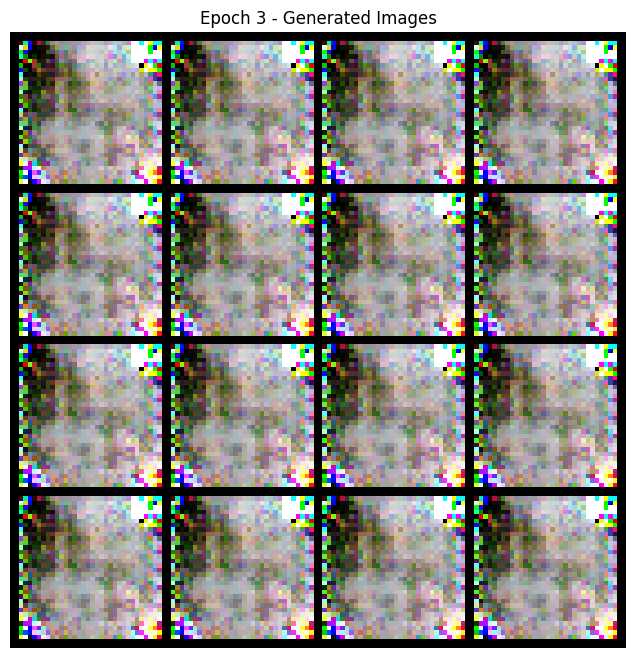

[Epoch 3/5] [Batch 0/1563] [D loss: 0.0003] [G loss: -0.3904]
[Epoch 3/5] [Batch 100/1563] [D loss: 0.0002] [G loss: -0.3903]
[Epoch 3/5] [Batch 200/1563] [D loss: 0.0001] [G loss: -0.3903]
[Epoch 3/5] [Batch 300/1563] [D loss: 0.0023] [G loss: -0.3905]
[Epoch 3/5] [Batch 400/1563] [D loss: 0.0005] [G loss: -0.3906]
[Epoch 3/5] [Batch 500/1563] [D loss: 0.0002] [G loss: -0.3906]
[Epoch 3/5] [Batch 600/1563] [D loss: 0.0003] [G loss: -0.3905]
[Epoch 3/5] [Batch 700/1563] [D loss: 0.0005] [G loss: -0.3905]
[Epoch 3/5] [Batch 800/1563] [D loss: 0.0001] [G loss: -0.3907]
[Epoch 3/5] [Batch 900/1563] [D loss: 0.0005] [G loss: -0.3906]
[Epoch 3/5] [Batch 1000/1563] [D loss: 0.0004] [G loss: -0.3906]
[Epoch 3/5] [Batch 1100/1563] [D loss: 0.0006] [G loss: -0.3908]
[Epoch 3/5] [Batch 1200/1563] [D loss: 0.0000] [G loss: -0.3908]
[Epoch 3/5] [Batch 1300/1563] [D loss: 0.0004] [G loss: -0.3907]
[Epoch 3/5] [Batch 1400/1563] [D loss: 0.0003] [G loss: -0.3905]
[Epoch 3/5] [Batch 1500/1563] [D loss

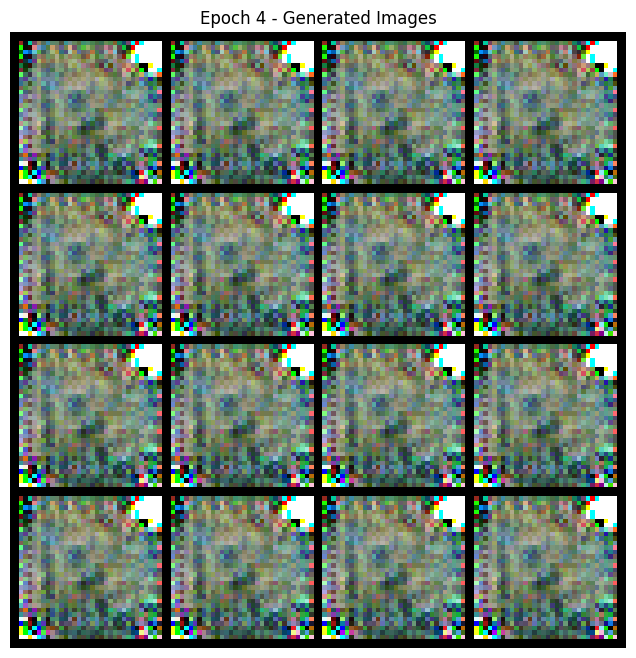

[Epoch 4/5] [Batch 0/1563] [D loss: 0.0012] [G loss: -0.3906]
[Epoch 4/5] [Batch 100/1563] [D loss: 0.0006] [G loss: -0.3904]
[Epoch 4/5] [Batch 200/1563] [D loss: 0.0001] [G loss: -0.3905]
[Epoch 4/5] [Batch 300/1563] [D loss: 0.0011] [G loss: -0.3906]
[Epoch 4/5] [Batch 400/1563] [D loss: 0.0005] [G loss: -0.3905]
[Epoch 4/5] [Batch 500/1563] [D loss: 0.0000] [G loss: -0.3906]
[Epoch 4/5] [Batch 600/1563] [D loss: 0.0000] [G loss: -0.3905]
[Epoch 4/5] [Batch 700/1563] [D loss: 0.0002] [G loss: -0.3904]
[Epoch 4/5] [Batch 800/1563] [D loss: 0.0010] [G loss: -0.3905]
[Epoch 4/5] [Batch 900/1563] [D loss: 0.0001] [G loss: -0.3904]
[Epoch 4/5] [Batch 1000/1563] [D loss: -0.0000] [G loss: -0.3904]
[Epoch 4/5] [Batch 1100/1563] [D loss: 0.0003] [G loss: -0.3905]
[Epoch 4/5] [Batch 1200/1563] [D loss: -0.0001] [G loss: -0.3904]
[Epoch 4/5] [Batch 1300/1563] [D loss: -0.0001] [G loss: -0.3903]
[Epoch 4/5] [Batch 1400/1563] [D loss: -0.0001] [G loss: -0.3904]
[Epoch 4/5] [Batch 1500/1563] [D 

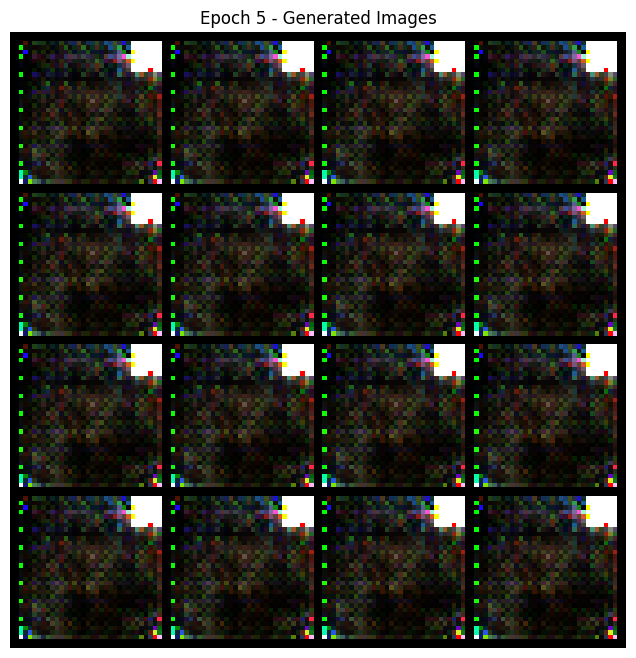

In [ ]:
# base code modified with GPT for robustness and loss tracking

# Lists to store losses
d_losses = []
g_losses = []

# Training Loop
for epoch in range(n_epochs):
    d_loss_epoch = 0.0  # Track total D loss per epoch
    g_loss_epoch = 0.0  # Track total G loss per epoch
    num_batches = len(dataloader)

    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator multiple times
        for _ in range(d_updates):
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(z)

            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs.detach())
            gp = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
            d_loss = (
                -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
            )

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Train Generator less frequently
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)
        fake_validity = discriminator(fake_imgs)
        g_loss = -torch.mean(fake_validity)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Accumulate losses
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

        # Print stats every 100 batches
        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )

    # Average losses for the epoch
    d_loss_epoch /= num_batches
    g_loss_epoch /= num_batches
    d_losses.append(d_loss_epoch)
    g_losses.append(g_loss_epoch)

    # Generate and display images at the end of each epoch
    with torch.no_grad():
        z = torch.zeros(16, latent_dim, device=device)  # Fixed noise for consistency
        generated_imgs = generator(z).cpu()
        generated_imgs = (generated_imgs + 1) / 2  # Rescale to [0, 1]

        grid = torchvision.utils.make_grid(generated_imgs, nrow=4)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0))  # Convert CHW to HWC
        plt.axis("off")
        plt.title(f"Epoch {epoch + 1} - Generated Images")
        plt.show()


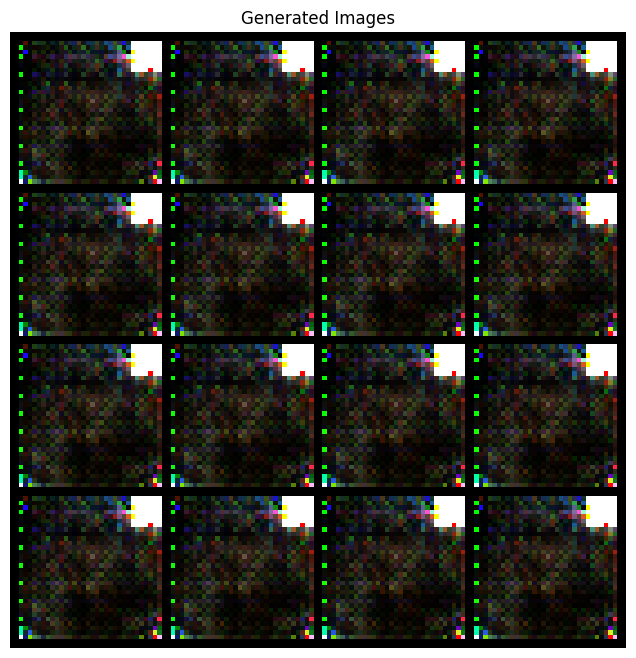

In [17]:
with torch.no_grad():
    z = torch.randn(16, latent_dim, device=device)
    generated_imgs = generator(z).cpu()
    generated_imgs = (generated_imgs + 1) / 2  # Rescale to [0, 1]

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Generated Images")
    plt.show()


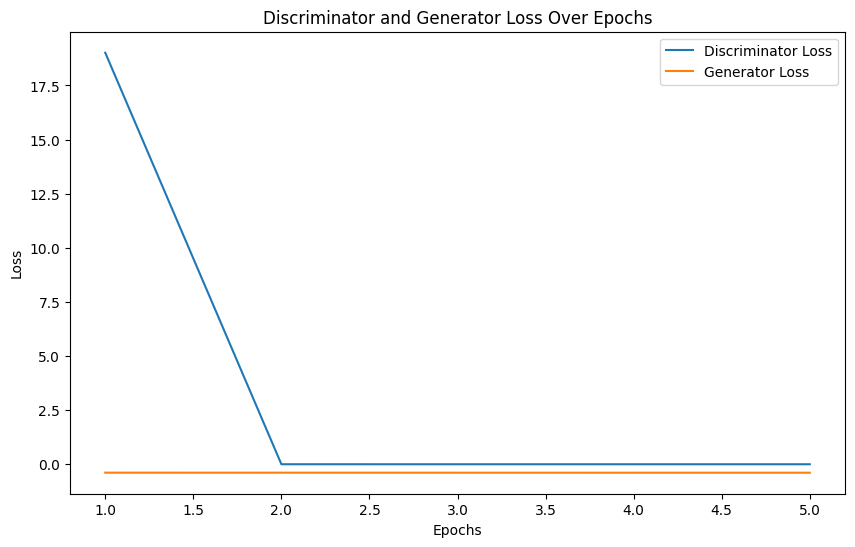

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), d_losses, label="Discriminator Loss")
plt.plot(range(1, n_epochs + 1), g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator and Generator Loss Over Epochs")
plt.legend()
plt.show()


Loss Behavior:

1. The discriminator loss starts high and drops quickly to near-zero, indicating the discriminator saturates and cannot distinguish between real and generated images.
2. The generator loss remains constant and close to 0, positve, meaning the generator is stuck producing repetitive outputs.
Generated Images:

All generated images are nearly identical, confirming severe mode collapse.

Next steps:
Fixing mode collapse

In [19]:
latent_dim = 128  # Increase latent space size
latent_dim = 100  # Size of the noise vector
image_size = 64  # Image dimensions (resized CIFAR-10)
batch_size = 128  # Batch size
n_epochs = 25  # Number of epochs
lr = 0.0002  # Learning rate
beta1 = 0.5  # Beta1 for Adam optimizer

In [20]:
# Data Preprocessing
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)


In [21]:
# Load CIFAR-10
dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform
    ),
    batch_size=batch_size,
    shuffle=True,
)


Files already downloaded and verified


In [34]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),  # Produces (batch_size, 1, 1, 1)
            nn.AdaptiveAvgPool2d(1),  # Ensure output is (batch_size, 1, 1)
            nn.Flatten(),  # Flatten to shape [batch_size]
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.model(img)  # Output: (batch_size)


In [35]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise for visualizing progress
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)

[Epoch 1/25] [D loss: 0.0185] [G loss: 7.7086]


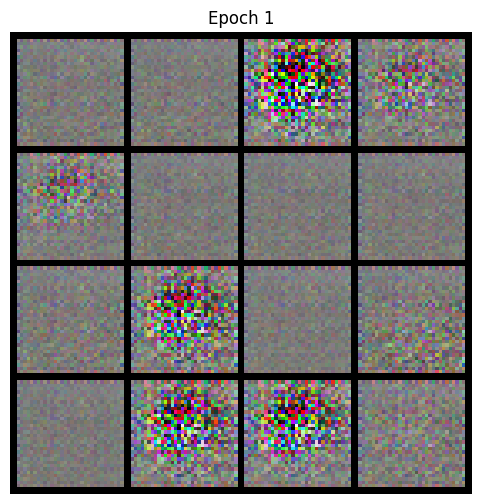

[Epoch 2/25] [D loss: 0.0004] [G loss: 9.2485]


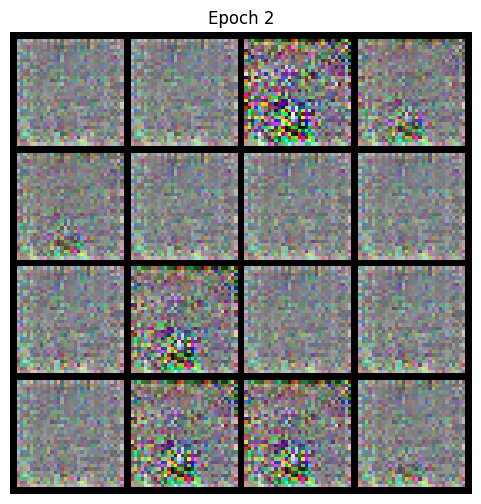

[Epoch 3/25] [D loss: 0.0001] [G loss: 10.0342]


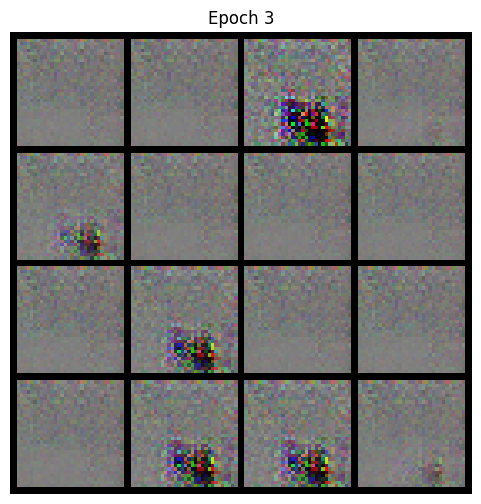

[Epoch 4/25] [D loss: 0.0001] [G loss: 10.7044]


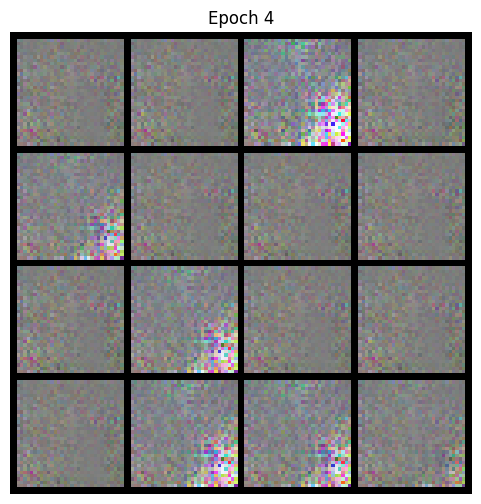

[Epoch 5/25] [D loss: 0.0000] [G loss: 11.0228]


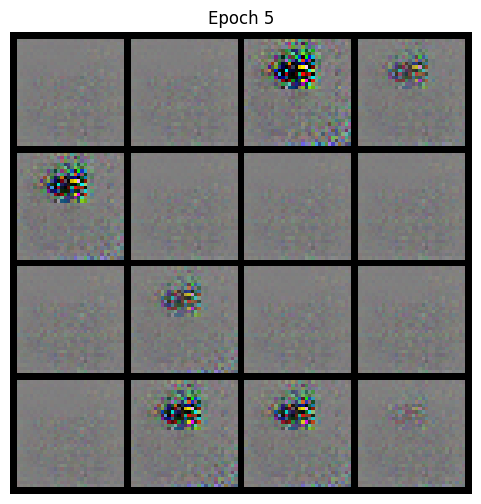

[Epoch 6/25] [D loss: 0.0000] [G loss: 11.6755]


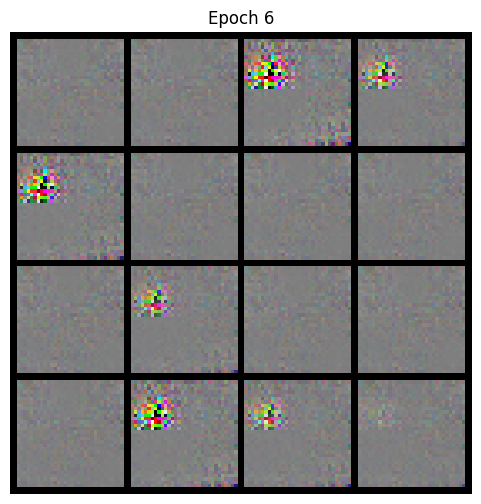

[Epoch 7/25] [D loss: 0.0000] [G loss: 11.9003]


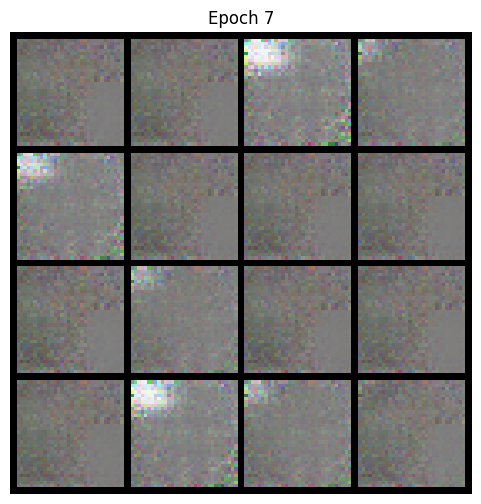

[Epoch 8/25] [D loss: 0.0000] [G loss: 12.1997]


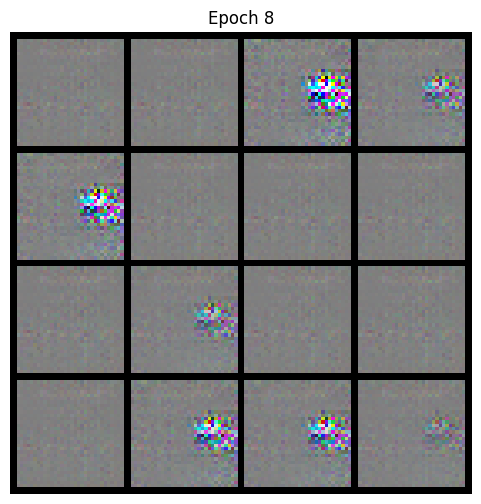

[Epoch 9/25] [D loss: 0.0000] [G loss: 12.3063]


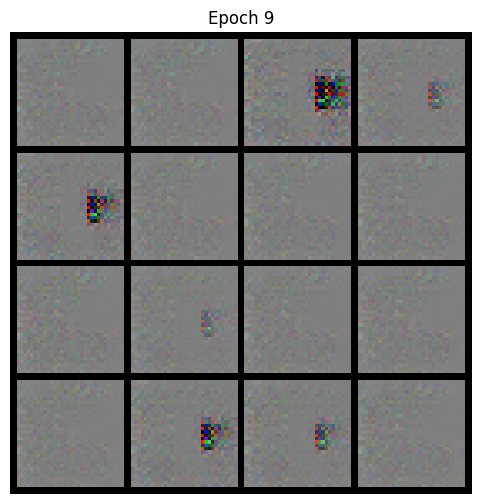

[Epoch 10/25] [D loss: 0.0000] [G loss: 13.0910]


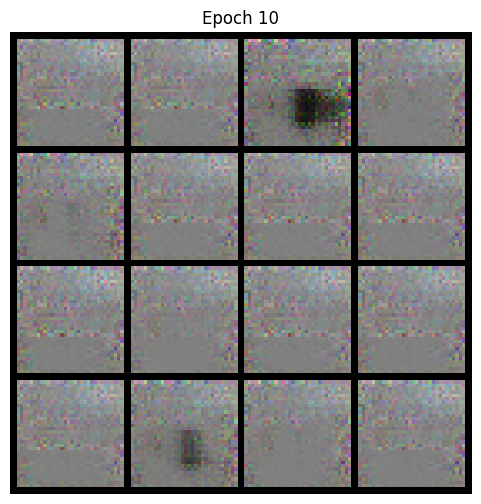

KeyboardInterrupt: 

In [37]:
# Loss tracking
d_losses = []
g_losses = []

# Training Loop
for epoch in range(n_epochs):
    d_loss_epoch, g_loss_epoch = 0.0, 0.0
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels with shape [batch_size, 1]
        real_labels = torch.ones((batch_size, 1), device=device)
        fake_labels = torch.zeros((batch_size, 1), device=device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = generator(z)

        real_output = discriminator(real_imgs)
        fake_output = discriminator(fake_imgs.detach())

        d_loss_real = criterion(real_output, real_labels)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        fake_output = discriminator(fake_imgs)
        g_loss = criterion(fake_output, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Accumulate losses
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

    d_losses.append(d_loss_epoch / len(dataloader))
    g_losses.append(g_loss_epoch / len(dataloader))

    # Print stats
    print(
        f"[Epoch {epoch + 1}/{n_epochs}] [D loss: {d_losses[-1]:.4f}] [G loss: {g_losses[-1]:.4f}]"
    )

    # Generate and visualize images
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).cpu()
        grid = torchvision.utils.make_grid(
            (fake_imgs + 1) / 2, nrow=4
        )  # Rescale to [0, 1]
        plt.figure(figsize=(6, 6))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.title(f"Epoch {epoch + 1}")
        plt.show()
